# CNN-lytical Assignment-2
<center>
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS7fZ0PJ4leQi4qtXR5Egv5YILqQqvzVSNtFg&usqp=CAU">
</center>

*  In this assignment, we will build a classifier for MNIST from using [PyTorch](https://pytorch.org/docs/stable/index.html). 

*   We will be using the same dataset as the previous assignment for MNIST. **Do not** use the complete MNIST dataset, even though PyTorch makes it really easy.

*   No limitations on your model this time, just don't use CNNs now, that's up next week.

**Feel free to redefine any function signatures below, just make sure the final cell remains the same.**

## Import libraries here
PyTorch, NumPy, Matplotlib, ...
Even when equipped with PyTorch, NumPy and Matplotlib make your work easier for visualization etc.

Also remember to **initialize the seed** for reproducibility of results, both for NumPy & PyTorch.

In [51]:
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim

## Load *Dataset*
Use the pickle file shared for the previous assignment here.

In [52]:
# mount Google Drive to access the dataset
from sklearn import preprocessing
# load the data set
file = 'train_data.pkl'
with open(file,'rb') as data:
    training_data = pickle.load(data)

X = training_data['X']
y = training_data['y']

# normalize
X_ = preprocessing.normalize(X)

# Split into X_train, y_train, X_test, y_test
# you can use stratified splitting from sklearn library
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.85)
print(X_train.shape)
print(y_train.shape)


(9000, 784)
(9000, 1)


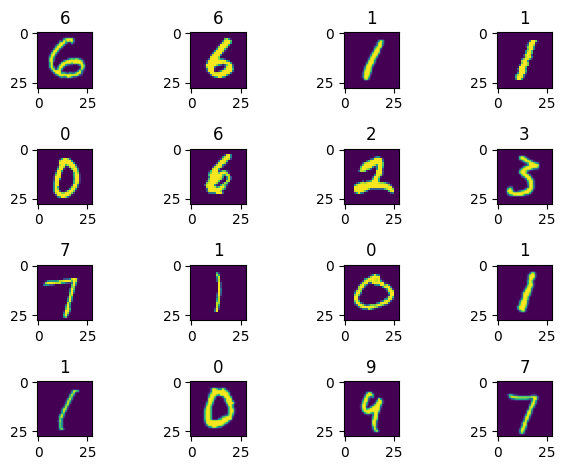

In [53]:
# display a 4x4 grid, 
# choose 16 images randomly, display the images as well as corresponding labels
size=X.shape[0]
for i in range(16):
    plt.subplot(4,4,i+1)
    j = np.random.randint(size)
    plt.imshow(X[j].reshape(28,28))
    plt.title(y[j][0])
plt.tight_layout()

## Creating a Dataset Class
In PyTorch, there is existing implementation of batch-splitting. You don't need to do it manually over here. Instead, just define a Dataset class and a Dataloader wrapping it.

A dataset class must have 3 functions - ```__init__```, ```__len__```, ```__getitem__```. Their names are pretty self-explanatory. You can read more about this [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).


**Note** - Things like normalization, augmentation etc. which are related to the dataset are all done in this class. However, because this assignment doesn't deal with MNIST images but rather feature vectors, this part is being skipped here and will be discussed in Assignment 3.

In [54]:
# define your dataset class
class mydataset(Dataset):
  def __init__(self, dataX, dataY):
    self.X_train = dataX
    self.y_train = dataY

  def __len__(self):
    return len(self.X_train)

  def __getitem__(self, idx):
    return (self.X_train[idx], self.y_train[idx])

## ```nn.Module``` for your model
In this segment, define a class for your model, it has to inherit from the ```nn.Module``` class. You must define two functions here - ```__init__``` and ```forward```, again pretty self-explanatory. Helper functions can also be implemented, your choice!

Look into the following ```torch``` layers and combine them to form your network, you can find more [here](https://pytorch.org/docs/stable/nn.html) -
- [```nn.Linear```](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
- [```nn.ReLU```](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)
- [```nn.BatchNorm1d```](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)


In [55]:
# define a child class of nn.Module for your model
# specify the architecture here itself
class neuralnetwork(nn.Module):
    def __init__(self):
        super(neuralnetwork, self).__init__()
        self.stack = nn.Sequential(
            nn.Linear(784, 392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.ReLU(),
            nn.Linear(196, 10)
        )
    def forward(self,x):
        return nn.functional.log_softmax(self.stack(x),dim = 1)



In [56]:
loss_fn = nn.NLLLoss()
model = neuralnetwork()
optimizer = optim.SGD(model.parameters(), lr = 0.001)
train_dataset = mydataset(X_train, y_train)
test_dataset = mydataset(X_test,y_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle = True)

## Training loop
You can write a training loop but usually writing it within a function helps so that you can train in multiple passes with just one function call if you still don't see convergence of the loss. ```display_step``` is for you to display results on the validation set (which you must not have trained upon).

You will need to use ```zero_grad()```, ```backward()``` and multiple such functions here. Look for them in the tutorials given.

In [57]:
def train(epoch, model, optimizer, train_loader, display_step=None):
    for X,y in train_loader:
        y = torch.reshape(y,(-1,))
        model.zero_grad()
        predict = model.forward(X.float())
        loss = loss_fn(predict,y.long())
        loss.backward()
        optimizer.step()
    print("Cost function after epoch ", epoch, "is :", loss.item())

## Initialize weights
Write a small function to initialize weights for your model. You don't need to do it individually for each layer, there are ways to do it in a simple ```for``` loop.

In [58]:
def init_weights():
    pass

## Prediction & Accuracy
Prediction function should predict outputs using your trained model for a given **NumPy array** ```X_test``` and the output should be another **NumPy array**.

The accuracy function would be the same as before.

In [59]:
def predict(model, X_test):
    X_test_ = torch.from_numpy(X_test).float()
    scores = model.forward(X_test_).detach().numpy()
    pred = scores.argmax(axis = 1,keepdims = True)
    return pred

In [60]:
def accuracy(pred, labels):
    size = pred.shape[0]
    correct = sum(pred[x][0] == labels[x][0] for x in range(size))
    print("accuracy =>", end = " ")
    print(100*correct/size)

## Actually training your model
- Create a model, initialize it. Define optimizer for the model as well as loss criterion (you can actually set the seed here again, just in case you did some ```rand``` calls above for testing your functions).
- Define an instance of the dataset class, wrap it in a dataloader.
- Call the train function and train your model!


In [64]:
for epoch in range(20):
    train(epoch+1, model, optimizer, train_loader)

Cost function after epoch  1 is : 0.0013545181136578321
Cost function after epoch  2 is : 0.0010494088055565953
Cost function after epoch  3 is : 0.0014374188613146544
Cost function after epoch  4 is : 0.0011147219920530915
Cost function after epoch  5 is : 0.0018737113568931818
Cost function after epoch  6 is : 0.0009557758457958698
Cost function after epoch  7 is : 0.0021214731968939304
Cost function after epoch  8 is : 0.00203106296248734
Cost function after epoch  9 is : 0.0015311165479943156
Cost function after epoch  10 is : 0.001333733438514173
Cost function after epoch  11 is : 0.00175581278745085
Cost function after epoch  12 is : 0.0010696128010749817
Cost function after epoch  13 is : 0.0013726011384278536
Cost function after epoch  14 is : 0.0016492207068949938
Cost function after epoch  15 is : 0.0016773855313658714
Cost function after epoch  16 is : 0.0010174226481467485
Cost function after epoch  17 is : 0.0017033523181453347
Cost function after epoch  18 is : 0.00088081

## Run your model for the validation dataset
Use your trained model to get predictions for the validation dataset you split earlier.

In [65]:
pred = predict(model, X_test)
accuracy(pred, y_test)

accuracy => 93.90392156862745


## Submission
To submit your solution, you will need to make a file with name ```model.py``` containing imports necessary to write the model class and the model class itself. It shouldn't do anything else when run. Other than this, save the trained model in a file named ```ass_2.pt```. When you are done with the assignment, commit the updated notebook, the ```model.py``` class file and the ```ass_2.pt``` model-weights file to the repository.

In [66]:
# from google.colab import files
torch.save(model, 'ass_2.pt')

Check if it got saved right!

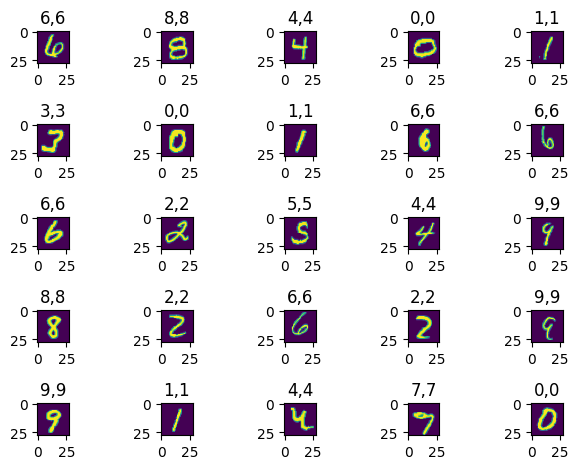

In [67]:
# load the model, use predict function
model = torch.load('ass_2.pt')
Ypred = predict(model,X)
size=X.shape[0]
for i in range(25):
    plt.subplot(5,5,i+1)
    j = np.random.randint(size)
    plt.imshow(X[j].reshape(28,28))
    title = str(Ypred[j][0])+ "," + str(y[j][0])
    plt.title(title)
plt.tight_layout()